In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

import keras
from keras.utils.np_utils import to_categorical
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras.layers import LeakyReLU
from keras.utils import plot_model
from sklearn.metrics import precision_recall_fscore_support


import xgboost as xgb

In [89]:
#https://matplotlib.org/3.1.0/gallery/pie_and_polar_charts/pie_and_donut_labels.html
def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} )".format(pct, absolute)

def drawPieChart(label,data,title):
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
    
        ax.annotate(label[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
    plt.title(title)
    plt.show()

In [157]:
df=pd.read_csv("cr_loan2.csv")
df.reset_index(inplace=True)
print(df.columns)

indices=df[df['loan_status'].isnull()].index
df.drop(indices,inplace=True)

indices=df[df['person_emp_length'].isnull()].index
df.drop(indices,inplace=True)

df.dropna(inplace=True)


Index(['index', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')


In [144]:
df['loan_percent_income']=df['loan_percent_income'].astype('float')
df['loan_amnt']=df['loan_amnt'].astype('float')
df['person_income']=df['person_income'].astype('float')
df['loan_int_rate']=df['loan_int_rate'].astype('float')
df['loan_intent']=df['loan_intent'].astype(str)
df['loan_grade']=df['loan_grade'].astype(str)

filter=(df['person_emp_length']<40) & (df['person_income']<500000)
df=df[filter]


df['age_type']=df['person_age'].apply(lambda row: "teenager" if (row<20)
                                     else "young adult" if (row>=20) & (row<30)
                                    else "adult" if (row>=30) & (row < 50)
                                      else "senior"
                                     )

#encoder=LabelEncoder()
#df["person_home_ownership_enc"]=encoder.fit_transform(df["person_home_ownership"])
#df["loan_grade_enc"]=encoder.fit_transform(df["loan_grade"])
#df["cb_person_default_on_file_enc"]=encoder.fit_transform(df["cb_person_default_on_file"])

cred_num  =df.select_dtypes(exclude=['object'])
cred_cat = df.select_dtypes(include=['object'])
ohe=pd.get_dummies(cred_cat)
df=pd.concat([df,ohe],axis=1)

print(df.columns)

Index(['index', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')
Index(['index', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length', 'age_type',
       'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_A',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F

In [110]:
interest_rate=df['loan_int_rate'].mean()
#print(interest_rate)
indices=df[df['loan_int_rate'].isnull()].index
filter=df.index.isin(indices)
indices=df['loan_int_rate'][filter].index

df.loc[indices,'loan_int_rate']=float(interest_rate)
#print(df[df['loan_int_rate']>=interest_rate])

In [111]:
print(df['person_home_ownership'].unique())
indices=df[df['person_home_ownership'].isnull()].index
df['person_home_ownership'][indices]='OTHER'

['OWN' 'MORTGAGE' 'RENT' 'OTHER']


C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\dnishimoto.BOISE\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


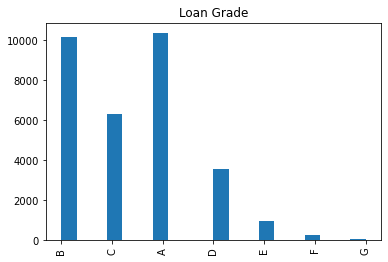

In [112]:
plt.hist(x=df['loan_grade'],bins=20)
plt.xticks(rotation=90)
plt.title("Loan Grade")
plt.show()

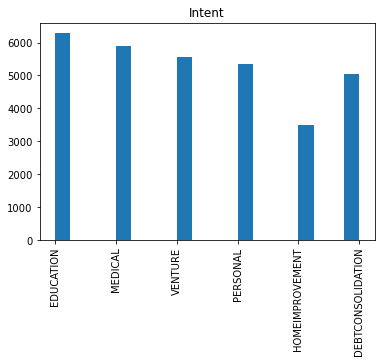

In [113]:
plt.hist(x=df['loan_intent'],bins=20)
plt.xticks(rotation=90)
plt.title("Intent")
plt.show()
#, 'loan_grade'

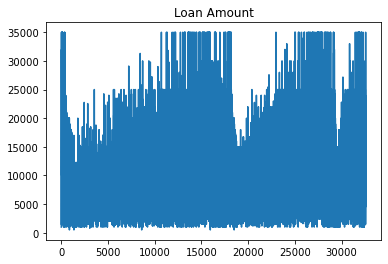

In [114]:
df['loan_amnt'].plot()
plt.title('Loan Amount')
plt.show()

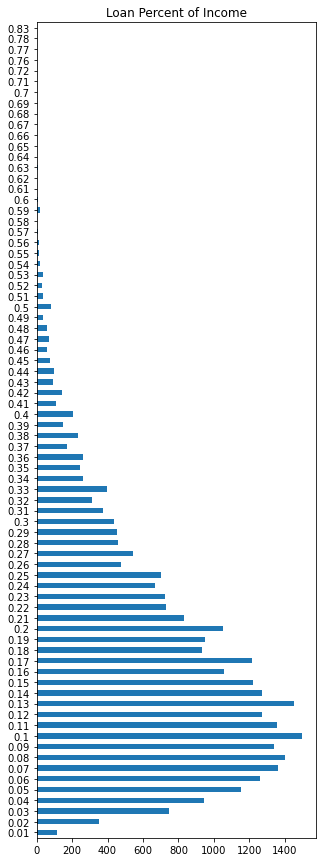

In [115]:
plt.figure(figsize=(5,15))
df['loan_percent_income'].value_counts().sort_index().plot(kind='barh')
plt.title('Loan Percent of Income')
plt.show()

In [116]:
print("Credit risk is the possiblity that the borrow will not repay the loan")

Credit risk is the possiblity that the borrow will not repay the loan


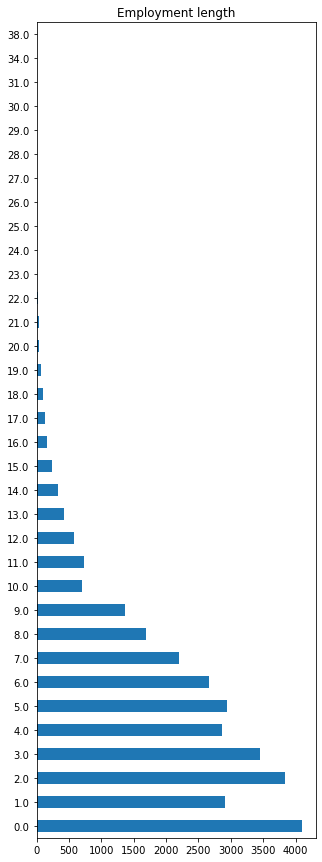

In [117]:
plt.figure(figsize=(5,15))
df['person_emp_length'].value_counts().sort_index().plot(kind='barh')
plt.title("Employment length")
plt.show()

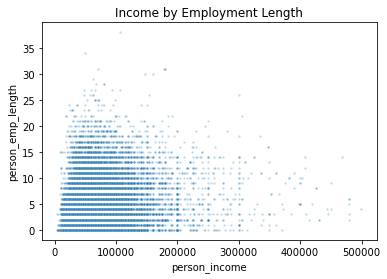

In [118]:
sns.scatterplot(x='person_income',y='person_emp_length',data=df,alpha=0.3,s=5)
plt.title('Income by Employment Length')
plt.show()

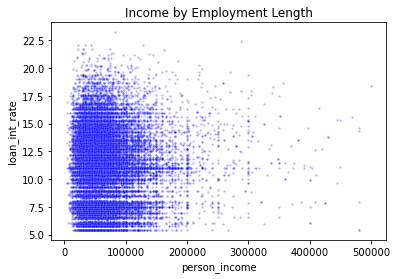

In [119]:
sns.scatterplot(x='person_income',y='loan_int_rate',color="blue", data=df,alpha=0.3,s=5)
plt.title('Income by Employment Length')
plt.show()

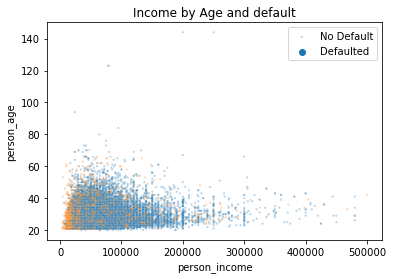

Ages 30 to 50 have higher incomes. Afterwhich incomes drop off in frequency


In [120]:
colors=['red','green']
sns.scatterplot(x='person_income',y='person_age',hue=df['loan_status'], 
                cmap = ListedColormap(colors),
                data=df,alpha=0.3,s=5)
plt.title('Income by Age and default')
plt.legend(['No Default', 'Defaulted'])
plt.show()

print("Ages 30 to 50 have higher incomes. Afterwhich incomes drop off in frequency")

<Figure size 432x288 with 0 Axes>

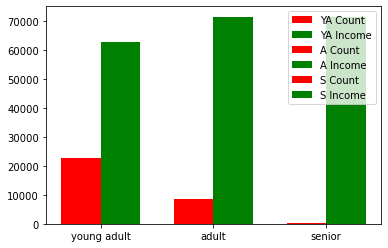

young adult (20-29) adult (30-49), senior (50-)


In [121]:
age_types=['young adult','adult','senior']
grouped=df.groupby('age_type')['person_income'].count()
grouped2=df.groupby('age_type')['person_income'].mean()

young_adult_count=(grouped['young adult'])
young_adult_income=(grouped2['young adult'])

adult_count=(grouped['adult'])
adult_income=(grouped2['adult'])

senior_count=(grouped['senior'])
senior_income=(grouped2['senior'])


plt.clf()
bar_width=.35
index=np.arange(len(age_types))
fig,ax=plt.subplots()
ya_count_bar=ax.bar(index[0]-(bar_width/2),young_adult_count,bar_width,label="YA Count",color='red')
ya_income_ba=ax.bar(index[0]+(bar_width/2),young_adult_income,bar_width,label="YA Income",color='green')

a_count_bar=ax.bar(index[1]-(bar_width/2),adult_count,bar_width,label="A Count",color='red')
a_income_ba=ax.bar(index[1]+(bar_width/2),adult_income,bar_width,label="A Income",color='green')

s_count_bar=ax.bar(index[2]-(bar_width/2),senior_count,bar_width,label="S Count",color='red')
s_income_ba=ax.bar(index[2]+(bar_width/2),senior_income,bar_width,label="S Income",color='green')

ax.set_xticks(index)
ax.set_xticklabels(age_types)

#plt.bar(grouped.index,grouped.values,label="Count",color='red')
#plt.bar(grouped2.index,grouped2.values,label="Avg Income", color="green")
plt.legend()

#plt.legend(['young adult (20-29)','adult (30-49), senior (50-)'])
plt.show()
print('young adult (20-29)','adult (30-49), senior (50-)')

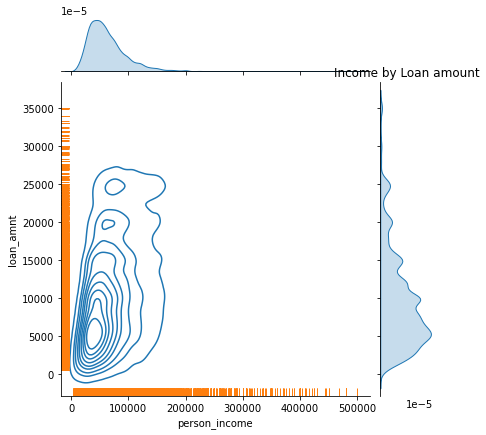

In [53]:
g=sns.JointGrid(data=df, x='person_income', y='loan_amnt')
g=g.plot_joint(sns.kdeplot)
g=g.plot_joint(sns.rugplot)
g=g.plot_marginals(sns.kdeplot,shade=True)
plt.title("Income by Loan amount")
plt.show()

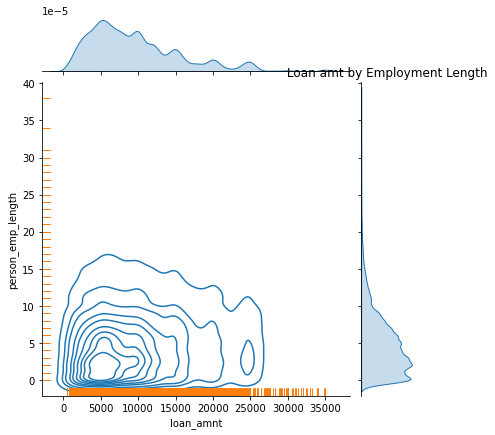

In [54]:
g=sns.JointGrid(data=df, x='loan_amnt', y='person_emp_length')
g=g.plot_joint(sns.kdeplot)
g=g.plot_joint(sns.rugplot)
g=g.plot_marginals(sns.kdeplot,shade=True)
plt.title("Loan amt by Employment Length")
plt.show()

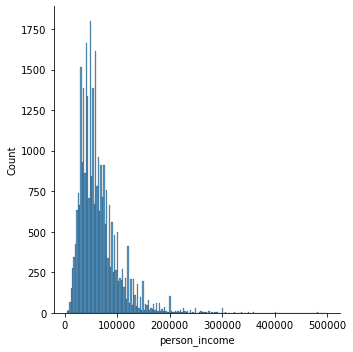

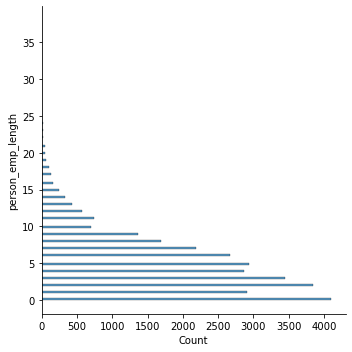

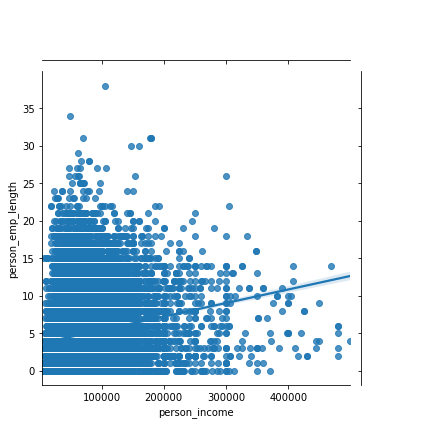

In [55]:
g=sns.JointGrid(data=df, x='person_income', y='person_emp_length')
#g=g.plot_joint(sns.kdeplot)
#g=g.plot_marginals(sns.kdeplot,shade=True)
g.plot(sns.regplot, sns.displot)
plt.show()

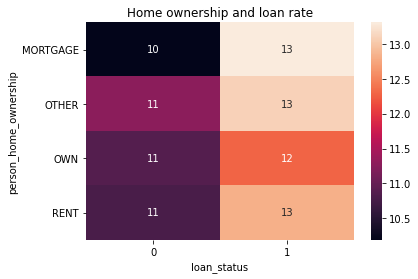

In [15]:
ct=pd.crosstab(df['person_home_ownership'],df['loan_status'],values=df['loan_int_rate'], aggfunc='mean').round(2)
sns.heatmap(ct,annot=True)
plt.title("Home ownership and loan rate")
plt.show()

<AxesSubplot:xlabel='loan_status', ylabel='loan_intent'>

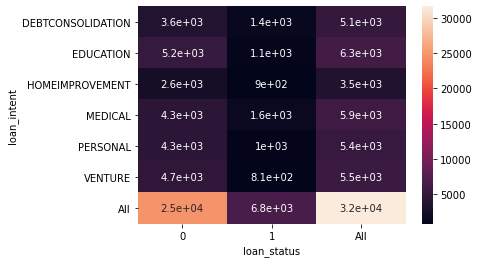

In [122]:
# Create a cross table of the loan intent and loan status
ct=(pd.crosstab(df["loan_intent"], df["loan_status"], margins = True))
sns.heatmap(ct,annot=True)

<AxesSubplot:xlabel='loan_status', ylabel='person_home_ownership'>

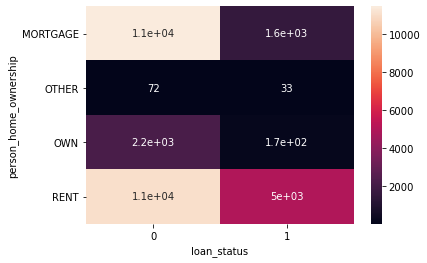

In [123]:
ct=(pd.crosstab(df["person_home_ownership"], df["loan_status"],df["loan_grade"],aggfunc='count'))
sns.heatmap(ct,annot=True)

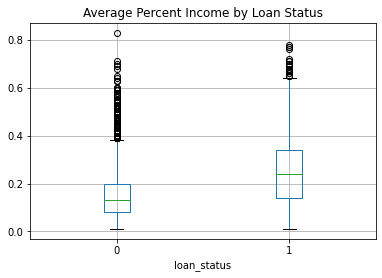

The average percentage of income for defaults is higher


In [124]:
df.boxplot(column = ["loan_percent_income"], by = "loan_status")
plt.title('Average Percent Income by Loan Status')
plt.suptitle('')
plt.show()

print("The average percentage of income for defaults is higher")

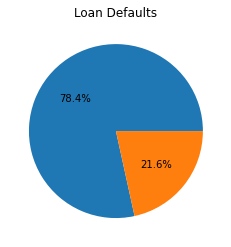

In [125]:
plt.pie(df['loan_status'].value_counts(),autopct='%1.1f%%')
plt.title('Loan Defaults')
plt.show()


In [126]:
pipeline = Pipeline([
    #('std', StandardScaler),
    ('lr', LogisticRegression(solver='lbfgs',penalty='l2',C=.1,tol=0.001,max_iter=100))
])

In [175]:
COLUMNS=[x for x in df.select_dtypes(exclude=['object']).columns if x!="loan status"]
print(COLUMNS)
X=df[COLUMNS]

y=df['loan_status']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=123)
pipeline['lr'].fit(X_train,y_train)



['index', 'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length']


LogisticRegression(C=0.1, tol=0.001)

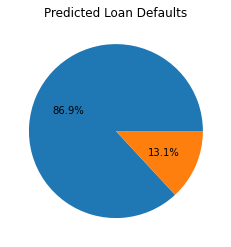

In [176]:
y_pred_prob=pipeline['lr'].predict_proba(X_test)

predictions=pipeline['lr'].predict(X_test)

plt.pie(pd.Series(predictions).value_counts(),autopct='%1.1f%%')
plt.title('Predicted Loan Defaults')
plt.show()


In [147]:
# Function to sort the list by second item of tuple
def Sort_Tuple(tup):
    tup.sort(key = lambda x: float(x[1]), reverse=True)
    return tup

print("Parameters",pipeline['lr'].get_params())
print("Intercept",pipeline['lr'].intercept_)
#print(pipeline['lr'].coef_)

print('\ncoefficients tell us the importance of each feature\n')

feature_coefficients=list(zip(COLUMNS,pipeline['lr'].coef_.T.flatten()))
for feature, coefficient in Sort_Tuple(feature_coefficients):
    print(feature,coefficient)

Parameters {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.001, 'verbose': 0, 'warm_start': False}
Intercept [-3.36856415e-09]

coefficients tell us the importance of each feature

loan_amnt 0.0001106188956416082
loan_int_rate 1.3764816215153387e-07
loan_status 6.431568332319738e-08
loan_grade_D 1.6644332206489397e-08
person_home_ownership_RENT 1.1923485821363262e-08
cb_person_default_on_file_Y 1.1203478533582212e-08
loan_grade_E 5.017606437193202e-09
loan_intent_DEBTCONSOLIDATION 4.1756024817690984e-09
cb_person_cred_hist_length 3.101511318142081e-09
loan_percent_income 2.805694618104537e-09
loan_intent_HOMEIMPROVEMENT 2.3948574943518596e-09
loan_intent_MEDICAL 2.2330026394091323e-09
loan_grade_F 1.5911542196422219e-09
loan_grade_G 6.331237283046989e-10
age_type_senior 3.4925447757986527e-10
age_type

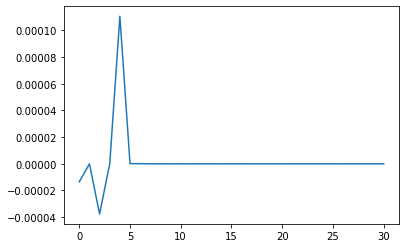

In [148]:
plt.plot(pipeline['lr'].coef_.flatten())

Loss: 2248


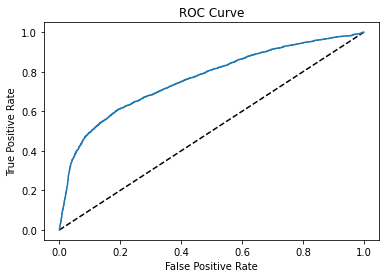

Model Accuracy=80.47
{'The more lift we have the larger the area under the curve'}


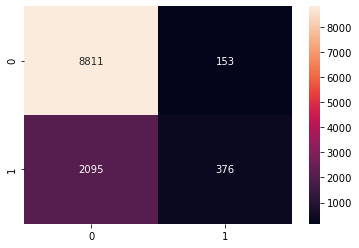

In [149]:
def my_loss(y,w):
    s = 0
    for i in range(y.size):
        # Get the true and predicted target values for example 'i'
        y_i_true = y[i]
        y_i_pred = w[i]
        s = s + (y_i_true - y_i_pred)**2
    return s

print("Loss:",my_loss(np.array(y_test),predictions))

fpr, tpr, threshholds = roc_curve(y_test,y_pred_prob[:,1])

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

accuracy=round(pipeline['lr'].score(X_train, y_train) * 100, 2)

print("Model Accuracy={accuracy}".format(accuracy=accuracy))

cm=confusion_matrix(y_test,predictions)

sns.heatmap(cm,annot=True,fmt="g")

print({"The more lift we have the larger the area under the curve"})

In [150]:
scaler=StandardScaler()
searcher = GridSearchCV(pipeline['lr'], {'C':[0.001, 0.01, 0.1, 1, 10],'tol':[0.001,0.0001,0.01,0.1,0.05,2,3]})
searcher.fit(scaler.fit_transform(X_train), y_train)

print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)

Best CV params {'C': 0.01, 'tol': 0.001}
Best CV accuracy 1.0


Text(0.5, 1.0, 'Predictions based on probabilities threshold')

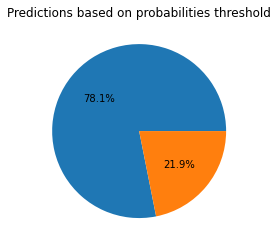

In [151]:
preds = pipeline['lr'].predict_proba(X_test)
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])
true_df=y_test
preds_df=pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1)
#print(preds_df)

#print("Actual defaults ", preds_df['loan_status'][preds_df['loan_status']==1].count())
#print("Predicted defaults ",preds_df['loan_status'][preds_df['prob_default']>=0.50].count())

threshold=0.35
preds_df['pred_loan_status']=preds_df['prob_default'].apply(lambda x: 1 if x>threshold else 0)
plt.pie(pd.Series(preds_df['pred_loan_status']).value_counts(),autopct='%1.1f%%')
plt.title("Predictions based on probabilities threshold")


In [152]:
print(classification_report(y_test,preds_df['pred_loan_status'], target_names=['Non default','Default']))

              precision    recall  f1-score   support

 Non default       0.87      0.87      0.87      8964
     Default       0.53      0.54      0.53      2471

    accuracy                           0.80     11435
   macro avg       0.70      0.70      0.70     11435
weighted avg       0.80      0.80      0.80     11435



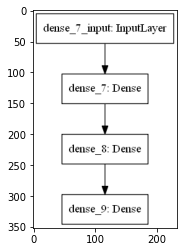

In [135]:
#https://www.bmc.com/blogs/keras-neural-network-classification/
model = Sequential()
model.add(Dense(len(COLUMNS), input_shape=(len(COLUMNS),),
               activation='tanh'
               ))
model.add(Dense(len(COLUMNS),activation='tanh'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])



plot_model(model, to_file='model.png')
img=plt.imread('model.png')
plt.imshow(img)
plt.show()


In [136]:
scaler=StandardScaler()
scaler.fit(X)
X2=scaler.transform(X)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history=model.fit(X,y, epochs = 20,verbose=1)
#history=model.fit(X_train,y_train,  epochs = 600)

# Evaluate your model 
print("Final lost value:",model.evaluate(X2,y))



Epoch 1/20
31626/31626 [==============================] - 1s 28us/step - loss: 0.4627 - accuracy: 0.8007
Epoch 2/20
31626/31626 [==============================] - 1s 26us/step - loss: 0.4540 - accuracy: 0.8107 1s - l
Epoch 3/20
31626/31626 [==============================] - 1s 24us/step - loss: 0.4470 - accuracy: 0.8175
Epoch 4/20
31626/31626 [==============================] - 1s 28us/step - loss: 0.4435 - accuracy: 0.8204
Epoch 5/20
31626/31626 [==============================] - 1s 25us/step - loss: 0.4435 - accuracy: 0.8237
Epoch 6/20
31626/31626 [==============================] - 1s 28us/step - loss: 0.4421 - accuracy: 0.8260
Epoch 7/20
31626/31626 [==============================] - 1s 28us/step - loss: 0.4398 - accuracy: 0.8262 0s - loss: 0.4387 - accu
Epoch 8/20
31626/31626 [==============================] - 1s 26us/step - loss: 0.4417 - accuracy: 0.8240
Epoch 9/20
31626/31626 [==============================] - 1s 25us/step - loss: 0.4396 - accuracy: 0.8264
Epoch 10/20
31626/31626

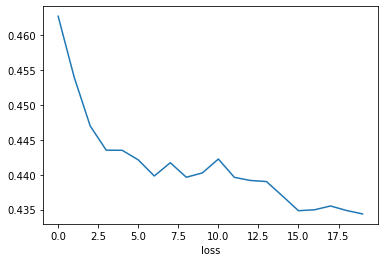

In [137]:
plt.figure()
plt.plot(history.history['loss'])
plt.xlabel('loss')
plt.show()

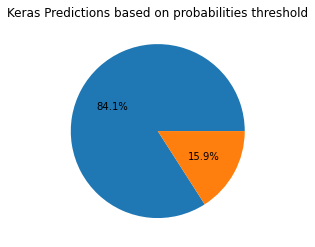

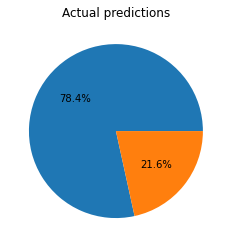

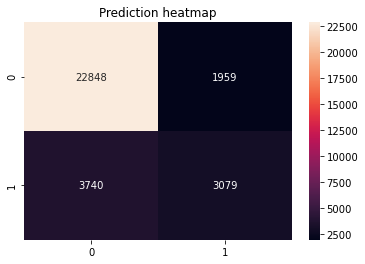

In [138]:
threshold=.275
prediction = model.predict(X[COLUMNS])
#print(prediction)

preds_df = pd.DataFrame(prediction, columns = ['pred_default_proba'])
true_df=y
preds_df=pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1)

preds_df['pred_loan_status']=preds_df['pred_default_proba'].apply(lambda row: 1 if row >threshold else 0)

plt.pie(preds_df['pred_loan_status'].value_counts(),autopct='%1.1f%%')
plt.title("Keras Predictions based on probabilities threshold")
plt.show()

plt.pie(preds_df['loan_status'].value_counts(),autopct='%1.1f%%')
plt.title("Actual predictions")
plt.show()    

cm=confusion_matrix(y,preds_df['pred_loan_status'])
sns.heatmap(cm,annot=True,fmt='g')
plt.title('Prediction heatmap')
plt.show()

In [139]:
# Print all the non-average values from the report
print(precision_recall_fscore_support(y,preds_df["pred_loan_status"])[0])

print(classification_report(y, preds_df['pred_loan_status'], target_names=['Non default','Default']))

[0.85933504 0.61115522]
              precision    recall  f1-score   support

 Non default       0.86      0.92      0.89     24807
     Default       0.61      0.45      0.52      6819

    accuracy                           0.82     31626
   macro avg       0.74      0.69      0.70     31626
weighted avg       0.81      0.82      0.81     31626



In [140]:
default_count=(X[X['loan_status']==1]['loan_status'].sum())
avg_loan_amt=(X[X['loan_status']==1]['loan_amnt'].mean())

print("Actual Default count {} Avg loan Amt {}".format(default_count,avg_loan_amt))

Actual Default count 6819 Avg loan Amt 11007.119812289193


In [141]:
pred_default_count=preds_df[preds_df['pred_loan_status']==1]['pred_loan_status'].sum()
print("Predicted Default count {}".format(pred_default_count))

Predicted Default count 5038


In [178]:
xg_cl= xgb.XGBClassifier(objective='binary:logistic',n_estimators=10,seed=123)

xg_cl.fit(X_train,y_train)


[16:47:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=4, num_parallel_tree=1, random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Predicted fraud count  2508


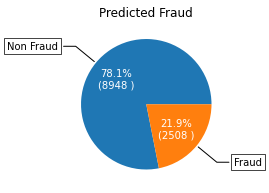

0    0
1    0
2    0
3    0
4    0
Name: loan_status, dtype: int64
0.0223284550011158 85000.0 
0.0223284550011158 52000.0 
0.0223284550011158 62000.0 
0.0223284550011158 31000.0 
0.0223284550011158 51000.0 
0.0223284550011158 71000.0 
0.9774936437606812 80001.0 
0.0223284550011158 104000.0 
0.0223284550011158 72000.0 
0.0223284550011158 110000.0 
0.0223284550011158 31500.0 
0.0223284550011158 67386.0 
0.0223284550011158 37000.0 
0.0223284550011158 50000.0 
0.0223284550011158 24996.0 
0.0223284550011158 90000.0 
0.0223284550011158 21888.0 
0.0223284550011158 55000.0 
0.0223284550011158 120000.0 
0.9774936437606812 18000.0 
0.0223284550011158 45000.0 
0.9774936437606812 30000.0 
0.0223284550011158 36000.0 
0.9774936437606812 136000.0 
0.9774936437606812 31200.0 
0.9774936437606812 17004.0 
0.9774936437606812 62900.0 
0.0223284550011158 63180.0 
0.0223284550011158 75797.0 
0.9774936437606812 29000.0 
0.9774936437606812 36228.0 
0.0223284550011158 130000.0 
0.0223284550011158 159996.0 
0.9

0.0223284550011158 54000.0 
0.0223284550011158 57000.0 
0.0223284550011158 60000.0 
0.0223284550011158 57200.0 
0.0223284550011158 110000.0 
0.0223284550011158 49000.0 
0.9774936437606812 91800.0 
0.0223284550011158 120000.0 
0.0223284550011158 121500.0 
0.0223284550011158 90000.0 
0.0223284550011158 34000.0 
0.0223284550011158 120000.0 
0.9774936437606812 31785.0 
0.0223284550011158 23000.0 
0.0223284550011158 62000.0 
0.0223284550011158 144000.0 
0.0223284550011158 65000.0 
0.9774936437606812 25920.0 
0.9774936437606812 28590.0 
0.0223284550011158 77004.0 
0.0223284550011158 110000.0 
0.0223284550011158 33000.0 
0.0223284550011158 100000.0 
0.0223284550011158 80000.0 
0.0223284550011158 68000.0 
0.0223284550011158 20800.0 
0.0223284550011158 114996.0 
0.0223284550011158 80000.0 
0.9774936437606812 123000.0 
0.0223284550011158 87504.0 
0.0223284550011158 93000.0 
0.0223284550011158 42000.0 
0.9774936437606812 28000.0 
0.0223284550011158 130000.0 
0.0223284550011158 107000.0 
0.0223284

0.0223284550011158 85000.0 
0.9774936437606812 43920.0 
0.0223284550011158 74000.0 
0.9774936437606812 34000.0 
0.0223284550011158 34800.0 
0.9774936437606812 20000.0 
0.0223284550011158 53000.0 
0.0223284550011158 120000.0 
0.0223284550011158 90000.0 
0.0223284550011158 140000.0 
0.0223284550011158 41500.0 
0.9774936437606812 56000.0 
0.0223284550011158 56000.0 
0.0223284550011158 75000.0 
0.9774936437606812 75000.0 
0.0223284550011158 150000.0 
0.0223284550011158 120000.0 
0.0223284550011158 95000.0 
0.0223284550011158 110000.0 
0.0223284550011158 32500.0 
0.0223284550011158 62000.0 
0.0223284550011158 64197.0 
0.0223284550011158 40000.0 
0.0223284550011158 36850.0 
0.9774936437606812 36000.0 
0.0223284550011158 60000.0 
0.0223284550011158 48000.0 
0.0223284550011158 60000.0 
0.0223284550011158 108000.0 
0.9774936437606812 42000.0 
0.0223284550011158 36000.0 
0.9774936437606812 29000.0 
0.0223284550011158 65000.0 
0.0223284550011158 48996.0 
0.0223284550011158 81000.0 
0.977493643760

0.0223284550011158 80000.0 
0.0223284550011158 40000.0 
0.0223284550011158 100000.0 
0.0223284550011158 70000.0 
0.9774936437606812 39896.0 
0.0223284550011158 70000.0 
0.0223284550011158 170000.0 
0.9774936437606812 19498.0 
0.9774936437606812 52000.0 
0.0223284550011158 54000.0 
0.0223284550011158 65200.0 
0.0223284550011158 130000.0 
0.0223284550011158 57204.0 
0.0223284550011158 36000.0 
0.0223284550011158 24000.0 
0.0223284550011158 66996.0 
0.0223284550011158 43000.0 
0.0223284550011158 103641.0 
0.0223284550011158 70004.0 
0.9774936437606812 50000.0 
0.9774936437606812 44400.0 
0.0223284550011158 26400.0 
0.9774936437606812 29000.0 
0.0223284550011158 100000.0 
0.0223284550011158 47500.0 
0.0223284550011158 69000.0 
0.0223284550011158 62000.0 
0.0223284550011158 45000.0 
0.0223284550011158 75000.0 
0.0223284550011158 30000.0 
0.0223284550011158 95000.0 
0.0223284550011158 24000.0 
0.0223284550011158 75000.0 
0.0223284550011158 21600.0 
0.0223284550011158 80000.0 
0.0223284550011

0.0223284550011158 32000.0 
0.0223284550011158 60000.0 
0.0223284550011158 72000.0 
0.0223284550011158 84000.0 
0.0223284550011158 60000.0 
0.0223284550011158 54000.0 
0.0223284550011158 39996.0 
0.0223284550011158 85000.0 
0.9774936437606812 33000.0 
0.0223284550011158 120000.0 
0.0223284550011158 39996.0 
0.9774936437606812 30000.0 
0.0223284550011158 78000.0 
0.9774936437606812 32000.0 
0.0223284550011158 76896.0 
0.0223284550011158 40000.0 
0.0223284550011158 60000.0 
0.0223284550011158 51800.0 
0.9774936437606812 54000.0 
0.0223284550011158 47000.0 
0.0223284550011158 130000.0 
0.0223284550011158 69500.0 
0.0223284550011158 77078.0 
0.0223284550011158 90200.0 
0.0223284550011158 46000.0 
0.0223284550011158 45000.0 
0.0223284550011158 75000.0 
0.0223284550011158 75000.0 
0.0223284550011158 55000.0 
0.0223284550011158 35220.0 
0.9774936437606812 50000.0 
0.0223284550011158 36000.0 
0.0223284550011158 105600.0 
0.9774936437606812 28000.0 
0.0223284550011158 99000.0 
0.022328455001115

0.0223284550011158 62000.0 
0.0223284550011158 120000.0 
0.0223284550011158 60000.0 
0.0223284550011158 95000.0 
0.0223284550011158 100000.0 
0.0223284550011158 21000.0 
0.9774936437606812 54000.0 
0.0223284550011158 60626.0 
0.9774936437606812 19200.0 
0.0223284550011158 65000.0 
0.9774936437606812 69846.0 
0.0223284550011158 31200.0 
0.0223284550011158 33000.0 
0.0223284550011158 60000.0 
0.9774936437606812 54000.0 
0.0223284550011158 200000.0 
0.0223284550011158 72000.0 
0.0223284550011158 49232.0 
0.0223284550011158 54600.0 
0.9774936437606812 94050.0 
0.9774936437606812 73000.0 
0.0223284550011158 60000.0 
0.0223284550011158 52992.0 
0.0223284550011158 53000.0 
0.0223284550011158 32000.0 
0.0223284550011158 53000.0 
0.0223284550011158 30000.0 
0.0223284550011158 30000.0 
0.0223284550011158 104000.0 
0.0223284550011158 46800.0 
0.0223284550011158 64000.0 
0.0223284550011158 35000.0 
0.0223284550011158 52000.0 
0.0223284550011158 95000.0 
0.0223284550011158 49296.0 
0.02232845500111

0.0223284550011158 20868.0 
0.0223284550011158 38000.0 
0.0223284550011158 60500.0 
0.0223284550011158 120000.0 
0.0223284550011158 91560.0 
0.9774936437606812 70550.0 
0.0223284550011158 80000.0 
0.9774936437606812 44000.0 
0.0223284550011158 31920.0 
0.0223284550011158 55000.0 
0.0223284550011158 24000.0 
0.0223284550011158 60000.0 
0.9774936437606812 30000.0 
0.9774936437606812 4000.0 
0.0223284550011158 48000.0 
0.0223284550011158 40000.0 
0.9774936437606812 72500.0 
0.0223284550011158 57000.0 
0.9774936437606812 28800.0 
0.0223284550011158 80000.0 
0.0223284550011158 51500.0 
0.0223284550011158 60000.0 
0.0223284550011158 54000.0 
0.0223284550011158 39312.0 
0.0223284550011158 48000.0 
0.0223284550011158 140000.0 
0.0223284550011158 80000.0 
0.0223284550011158 78300.0 
0.0223284550011158 88900.0 
0.0223284550011158 64000.0 
0.0223284550011158 60000.0 
0.0223284550011158 30000.0 
0.9774936437606812 51000.0 
0.0223284550011158 79600.0 
0.9774936437606812 36000.0 
0.0223284550011158 

0.9774936437606812 26500.0 
0.9774936437606812 88000.0 
0.0223284550011158 48000.0 
0.9774936437606812 34819.0 
0.0223284550011158 79200.0 
0.0223284550011158 105000.0 
0.0223284550011158 100000.0 
0.0223284550011158 40740.0 
0.0223284550011158 52800.0 
0.0223284550011158 108000.0 
0.0223284550011158 108000.0 
0.0223284550011158 48956.0 
0.9774936437606812 32000.0 
0.0223284550011158 95000.0 
0.0223284550011158 46000.0 
0.0223284550011158 36000.0 
0.0223284550011158 61000.0 
0.0223284550011158 68004.0 
0.0223284550011158 25000.0 
0.0223284550011158 50004.0 
0.9774936437606812 44000.0 
0.9774936437606812 49777.0 
0.0223284550011158 33000.0 
0.9774936437606812 78000.0 
0.0223284550011158 170000.0 
0.9774936437606812 44004.0 
0.0223284550011158 80000.0 
0.0223284550011158 50000.0 
0.9774936437606812 29000.0 
0.9774936437606812 40000.0 
0.0223284550011158 52000.0 
0.0223284550011158 82300.0 
0.0223284550011158 18000.0 
0.9774936437606812 58000.0 
0.0223284550011158 64000.0 
0.0223284550011

0.0223284550011158 37308.0 
0.0223284550011158 50000.0 
0.0223284550011158 46776.0 
0.0223284550011158 38000.0 
0.0223284550011158 60000.0 
0.0223284550011158 130000.0 
0.0223284550011158 30720.0 
0.9774936437606812 36000.0 
0.0223284550011158 36996.0 
0.9774936437606812 56000.0 
0.0223284550011158 83600.0 
0.0223284550011158 42000.0 
0.0223284550011158 70000.0 
0.0223284550011158 45000.0 
0.0223284550011158 100000.0 
0.0223284550011158 76000.0 
0.0223284550011158 63000.0 
0.0223284550011158 170000.0 
0.0223284550011158 123996.0 
0.9774936437606812 36000.0 
0.9774936437606812 72000.0 
0.9774936437606812 39000.0 
0.0223284550011158 35000.0 
0.9774936437606812 73000.0 
0.0223284550011158 70000.0 
0.0223284550011158 38000.0 
0.0223284550011158 110000.0 
0.0223284550011158 35100.0 
0.0223284550011158 110000.0 
0.0223284550011158 70000.0 
0.0223284550011158 53000.0 
0.0223284550011158 20000.0 
0.0223284550011158 139000.0 
0.0223284550011158 101000.0 
0.0223284550011158 63000.0 
0.9774936437

0.0223284550011158 65000.0 
0.0223284550011158 102300.0 
0.0223284550011158 60000.0 
0.0223284550011158 42240.0 
0.0223284550011158 130000.0 
0.9774936437606812 60520.0 
0.0223284550011158 16800.0 
0.0223284550011158 48000.0 
0.0223284550011158 130000.0 
0.0223284550011158 28800.0 
0.9774936437606812 40800.0 
0.0223284550011158 120456.0 
0.9774936437606812 44000.0 
0.0223284550011158 39996.0 
0.0223284550011158 57000.0 
0.0223284550011158 109000.0 
0.0223284550011158 60000.0 
0.0223284550011158 70000.0 
0.9774936437606812 19200.0 
0.0223284550011158 45000.0 
0.9774936437606812 51000.0 
0.0223284550011158 96000.0 
0.0223284550011158 67200.0 
0.0223284550011158 84000.0 
0.0223284550011158 84000.0 
0.9774936437606812 30000.0 
0.9774936437606812 38004.0 
0.0223284550011158 54996.0 
0.0223284550011158 66000.0 
0.0223284550011158 83000.0 
0.0223284550011158 53000.0 
0.9774936437606812 54000.0 
0.0223284550011158 96000.0 
0.9774936437606812 70550.0 
0.9774936437606812 39996.0 
0.0223284550011

0.0223284550011158 32700.0 
0.0223284550011158 45000.0 
0.9774936437606812 39600.0 
0.0223284550011158 54566.0 
0.0223284550011158 88000.0 
0.0223284550011158 45000.0 
0.0223284550011158 25500.0 
0.9774936437606812 54000.0 
0.0223284550011158 175000.0 
0.9774936437606812 18000.0 
0.0223284550011158 200000.0 
0.0223284550011158 80000.0 
0.0223284550011158 77250.0 
0.0223284550011158 66000.0 
0.0223284550011158 51000.0 
0.9774936437606812 25000.0 
0.9774936437606812 26400.0 
0.0223284550011158 70000.0 
0.0223284550011158 42000.0 
0.0223284550011158 50000.0 
0.9774936437606812 138000.0 
0.0223284550011158 22300.0 
0.0223284550011158 70000.0 
0.0223284550011158 105000.0 
0.9774936437606812 42765.0 
0.9774936437606812 35000.0 
0.0223284550011158 165000.0 
0.0223284550011158 60000.0 
0.0223284550011158 85000.0 
0.0223284550011158 35100.0 
0.0223284550011158 83000.0 
0.9774936437606812 81000.0 
0.9774936437606812 36000.0 
0.0223284550011158 65000.0 
0.0223284550011158 60000.0 
0.0223284550011

0.0223284550011158 40992.0 
0.0223284550011158 70600.0 
0.0223284550011158 120000.0 
0.0223284550011158 56000.0 
0.0223284550011158 55000.0 
0.9774936437606812 48000.0 
0.0223284550011158 45600.0 
0.0223284550011158 95000.0 
0.9774936437606812 55000.0 
0.9774936437606812 138550.0 
0.0223284550011158 45000.0 
0.9774936437606812 60500.0 
0.0223284550011158 47508.0 
0.0223284550011158 55000.0 
0.9774936437606812 25200.0 
0.9774936437606812 27000.0 
0.0223284550011158 42000.0 
0.0223284550011158 35000.0 
0.9774936437606812 19000.0 
0.0223284550011158 23198.0 
0.0223284550011158 75996.0 
0.9774936437606812 25000.0 
0.0223284550011158 54099.0 
0.0223284550011158 105000.0 
0.0223284550011158 50000.0 
0.0223284550011158 60000.0 
0.0223284550011158 63000.0 
0.0223284550011158 50000.0 
0.0223284550011158 56000.0 
0.9774936437606812 49200.0 
0.0223284550011158 55704.0 
0.0223284550011158 72800.0 
0.0223284550011158 29996.0 
0.9774936437606812 42600.0 
0.0223284550011158 70000.0 
0.022328455001115

0.0223284550011158 28000.0 
0.0223284550011158 42000.0 
0.0223284550011158 60000.0 
0.9774936437606812 36500.0 
0.0223284550011158 41300.0 
0.9774936437606812 17721.0 
0.9774936437606812 23196.0 
0.0223284550011158 98000.0 
0.0223284550011158 163232.0 
0.0223284550011158 306000.0 
0.0223284550011158 84000.0 
0.0223284550011158 29553.0 
0.9774936437606812 19200.0 
0.0223284550011158 49510.0 
0.9774936437606812 55200.0 
0.9774936437606812 14400.0 
0.9774936437606812 59000.0 
0.0223284550011158 45000.0 
0.0223284550011158 42240.0 
0.0223284550011158 55000.0 
0.0223284550011158 43000.0 
0.0223284550011158 50000.0 
0.9774936437606812 54400.0 
0.0223284550011158 50000.0 
0.0223284550011158 45312.0 
0.0223284550011158 76500.0 
0.0223284550011158 38000.0 
0.0223284550011158 50400.0 
0.0223284550011158 85000.0 
0.0223284550011158 120000.0 
0.0223284550011158 69996.0 
0.0223284550011158 27302.0 
0.0223284550011158 47412.0 
0.0223284550011158 85000.0 
0.0223284550011158 65000.0 
0.022328455001115

0.0223284550011158 78000.0 
0.0223284550011158 110000.0 
0.0223284550011158 73000.0 
0.9774936437606812 65000.0 
0.0223284550011158 480000.0 
0.0223284550011158 45000.0 
0.0223284550011158 50000.0 
0.0223284550011158 109920.0 
0.9774936437606812 36000.0 
0.0223284550011158 40000.0 
0.0223284550011158 50000.0 
0.9774936437606812 72250.0 
0.0223284550011158 70000.0 
0.9774936437606812 78200.0 
0.0223284550011158 50400.0 
0.0223284550011158 35000.0 
0.0223284550011158 32000.0 
0.0223284550011158 41004.0 
0.9774936437606812 33000.0 
0.0223284550011158 105500.0 
0.0223284550011158 170000.0 
0.9774936437606812 35000.0 
0.0223284550011158 43000.0 
0.0223284550011158 381450.0 
0.9774936437606812 17496.0 
0.0223284550011158 44000.0 
0.0223284550011158 93000.0 
0.0223284550011158 31200.0 
0.0223284550011158 87000.0 
0.0223284550011158 71004.0 
0.0223284550011158 102000.0 
0.0223284550011158 25200.0 
0.0223284550011158 100000.0 
0.0223284550011158 60000.0 
0.0223284550011158 37980.0 
0.0223284550

0.0223284550011158 36000.0 
0.0223284550011158 118000.0 
0.0223284550011158 70000.0 
0.0223284550011158 100000.0 
0.0223284550011158 31776.0 
0.0223284550011158 100000.0 
0.0223284550011158 38400.0 
0.0223284550011158 41000.0 
0.9774936437606812 55250.0 
0.0223284550011158 61800.0 
0.0223284550011158 47000.0 
0.0223284550011158 97500.0 
0.0223284550011158 121000.0 
0.0223284550011158 78000.0 
0.9774936437606812 26000.0 
0.0223284550011158 45000.0 
0.0223284550011158 35000.0 
0.0223284550011158 48000.0 
0.0223284550011158 40000.0 
0.0223284550011158 50000.0 
0.0223284550011158 100000.0 
0.9774936437606812 29000.0 
0.9774936437606812 30000.0 
0.0223284550011158 80000.0 
0.9774936437606812 52000.0 
0.0223284550011158 66600.0 
0.9774936437606812 74000.0 
0.0223284550011158 155142.0 
0.0223284550011158 85000.0 
0.9774936437606812 51996.0 
0.0223284550011158 98000.0 
0.9774936437606812 18000.0 
0.9774936437606812 88000.0 
0.9774936437606812 77350.0 
0.9774936437606812 54000.0 
0.022328455001

0.0223284550011158 165000.0 
0.0223284550011158 150000.0 
0.0223284550011158 57000.0 
0.0223284550011158 82000.0 
0.0223284550011158 320000.0 
0.0223284550011158 99996.0 
0.9774936437606812 54000.0 
0.0223284550011158 40000.0 
0.0223284550011158 103000.0 
0.0223284550011158 135000.0 
0.0223284550011158 53000.0 
0.9774936437606812 30000.0 
0.0223284550011158 35400.0 
0.0223284550011158 90000.0 
0.0223284550011158 70000.0 
0.0223284550011158 48000.0 
0.0223284550011158 445000.0 
0.9774936437606812 23040.0 
0.9774936437606812 33000.0 
0.0223284550011158 78000.0 
0.0223284550011158 115000.0 
0.0223284550011158 87800.0 
0.9774936437606812 34000.0 
0.0223284550011158 30000.0 
0.0223284550011158 170000.0 
0.0223284550011158 62000.0 
0.0223284550011158 77248.0 
0.0223284550011158 50600.0 
0.9774936437606812 36000.0 
0.9774936437606812 39000.0 
0.0223284550011158 65000.0 
0.9774936437606812 29004.0 
0.9774936437606812 137400.0 
0.9774936437606812 144996.0 
0.0223284550011158 143000.0 
0.9774936

In [212]:
y_pred=xg_cl.predict(X_test)
y_pred_proba=xg_cl.predict_proba(X_test)

preds_proba_df = pd.DataFrame(y_pred_proba[:,1], columns = ['prob_default'])

print("Predicted fraud count ",len(y_pred[y_pred==1]))
buffer=pd.Series(y_pred)
#buffer.value_counts().plot(kind='pie')
#plt.show()

drawPieChart(['Non Fraud','Fraud'],buffer.value_counts(),"Predicted Fraud")

preds_df=pd.DataFrame(X_test)
#preds_df=preds_df.reset_index()
#true_df=pd.DataFrame(y_test['loan_status'],columns=['loan_status'])
preds_df=pd.concat([preds_df.reset_index(drop=True),preds_proba_df],axis=1)
preds_df.dropna(inplace=True)
print(preds_df['loan_status'].head())
for key,item  in preds_df.iterrows():
    #if item['loan_status']==1:
    print("{} {} ".format(item['prob_default'],item['person_income']))
